# Analyse individual agent balance sheets JMAB

In [88]:
%matplotlib inline 
from pandas import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
import os
from scipy.signal import savgol_filter

In [2]:
style.use('seaborn-whitegrid')
style.use('seaborn-colorblind')

In [3]:
#%cd C:/Users/joeri/workspace/interbank/data    
%cd C:/Users/p267237/Desktop/data

C:\Users\p267237\Desktop\data


In [4]:
def allRuns(generalFileName):
    """Combine all run files for a dataframe and return a dataframe"""
    listOfFiles= [x for x in os.listdir() if '.csv' in x]
    fileSeries = {}
    for file in listOfFiles:
        if (generalFileName in file) and (file.index(generalFileName) == 0):
            # read file 
            print(file)
            fileData = read_csv(file, header=None).drop(0, 1)
            # loop over columns 
            counter = 0
            for column in fileData:
                fileSeries[file[:-4] + '-{}'.format(counter)] = fileData[column]
                counter += 1
    return DataFrame(fileSeries)

In [5]:
def aggregateMicroData(df, nRuns):
    """return a dataframe with aggregate micro data given the number of simulations"""
    runs = [str(x+1) + '-' for x in range(nRuns)]
    runAndColumn = {}
    for run in runs:
        runAndColumn[run] = []
        for col in df.columns:
            if run in col:
                runAndColumn[run].append(col)
    sumPerRun = {}
    for key in runAndColumn:
        sumPerRun['agg-' + key] = df[runAndColumn[key]].sum(axis=1)
    return DataFrame(sumPerRun)

In [6]:
def averageMicroData(df, nRuns):
    """return a dataframe with average micro data given the number of simulations"""
    runs = [str(x+1) + '-' for x in range(nRuns)]
    runAndColumn = {}
    for run in runs:
        runAndColumn[run] = []
        for col in df.columns:
            if run in col:
                runAndColumn[run].append(col)
    sumPerRun = {}
    for key in runAndColumn:
        sumPerRun['agg-' + key] = df[runAndColumn[key]].mean(axis=1)
    return DataFrame(sumPerRun)

In [7]:
def renameBalanceSheetColumns(df):
    """takes an aggregated balance sheet dataFrame and names the columns with balance sheet items"""
    stocks = {'cash': 0, 'deposits': 1, 'consumer-goods': 2, 'capital-goods': 3, 
          'loans': 4, 'bonds': 5, 'reserves': 6, 'advances': 7, 'interbank': 8}
    colNames = df.columns.values
    newColNames = []
    for name in colNames:
        for stock in stocks:
            if ('-' + str(stocks[stock])) in name:
                newName = name[:-1] + stock
                newColNames.append(newName)
    df.columns = newColNames
    return(df)

In [138]:
START = 0
PERIODEND = 126

# 1 Aggregate dynamics

## 1.1 Unemployment

In [55]:
unemployment = read_csv('unemployment1.csv', header=None).drop(0, 1)
unemployment.rename(columns={1: 'Unempl'}, inplace=True)

In [56]:
bankruptcies = read_csv('cFirmsBankrupcty1.csv', header=None).drop(0,1)
bankruptcies.rename(columns={1:'bankr'}, inplace=True)

(0, 126)

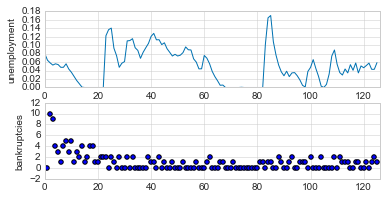

In [139]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3))

ax1.plot(unemployment.index[START:PERIODEND], unemployment[START:PERIODEND])
ax1.set_ylabel('unemployment')
ax1.set_xlim(START, PERIODEND)
ax2.scatter(bankruptcies.index[START:PERIODEND], bankruptcies[START:PERIODEND])
ax2.set_ylabel('bankruptcies')
ax2.set_xlim(START, PERIODEND)

## 1.2 Inflation

In [105]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [70]:
cPrices = averageMicroData(allRuns('cFirmsPrices'),1)

cFirmsPrices1.csv


In [143]:
inflation = savitzky_golay(np.array(cPrices[START:PERIODEND].diff()[1:]['agg-1-']),51,3)

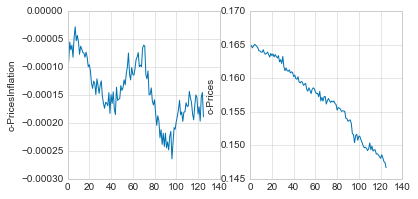

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.plot(cPrices.index[START+1:PERIODEND], inflation)
ax1.plot(cPrices.index[START+1:PERIODEND], [0 for x in cPrices.index[START+1:PERIODEND]], 'k--')
ax1.set_ylabel('c-PricesInflation')

ax2.plot(cPrices.index[START:PERIODEND], np.array(cPrices[START:PERIODEND]))
ax2.set_ylabel('c-Prices')

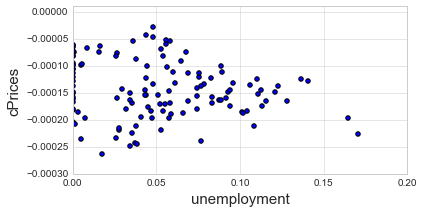

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.scatter(unemployment[START+1:PERIODEND], inflation)
ax.set_ylabel('cPrices', fontsize='15')
ax.set_xlabel('unemployment', fontsize='15')

ax.set_ylim(-0.0003, 0.00001)
ax.set_xlim(0, 0.20)

fig.savefig('shortRunPhilipsCurve')

## 1.3 GDP and its components

In [72]:
GDP = read_csv('nominalGDP1.csv', header=None).drop(0, 1)
GDP.rename(columns={1: 'GDP'}, inplace=True)

In [73]:
nomInvestment = read_csv('nominalInvestment1.csv', header=None).drop(0, 1)
nomInvestment.rename(columns={1: 'nomInv'}, inplace=True)

In [74]:
nomCons = aggregateMicroData(allRuns('hhNominalConsumption'), 1)

hhNominalConsumption1.csv


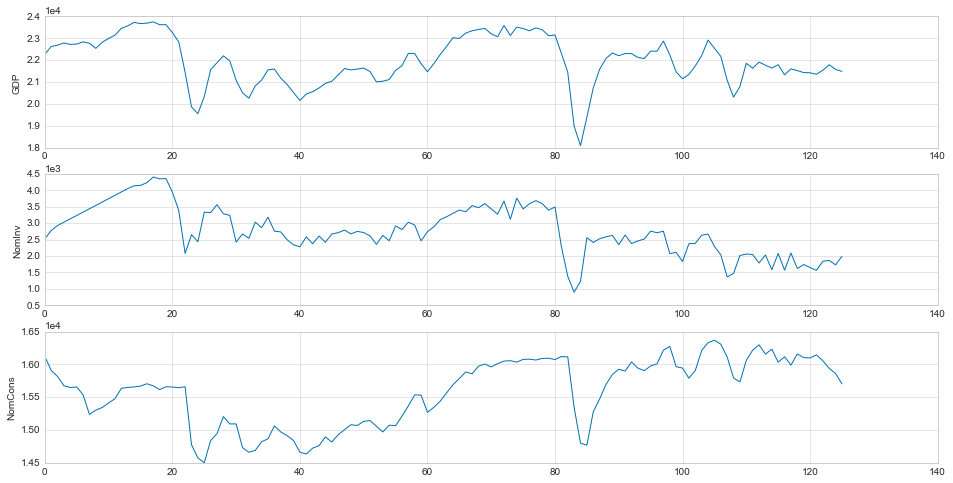

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))


ax1.plot(GDP.index[START:PERIODEND], GDP[START:PERIODEND])
ax1.set_ylabel('GDP')
ax2.plot(nomInvestment.index[START:PERIODEND], nomInvestment[START:PERIODEND])
ax2.set_ylabel('NomInv')
ax3.plot(nomCons.index[START:PERIODEND], nomCons[START:PERIODEND])
ax3.set_ylabel('NomCons')

for ax in (ax1, ax2, ax3):
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# TODO Business cycle
http://dismalpy.github.io/user/_notebooks/structural_harvey_jaeger.ipynb.html

## 2 Households



In [24]:
hhAvNetIncome = read_csv('hhAvNetIncome1.csv', header=None).drop(0, 1)
hhAvNetIncome.rename(columns={1: 'hhAvNetIncome'}, inplace=True)
hhAvWage = read_csv('hhAvWage1.csv', header=None).drop(0, 1)
hhAvWage.rename(columns={1: 'hhAvWage'}, inplace=True)
hhRealDesiredConsumption = aggregateMicroData(allRuns('hhRealDesiredConsumption'),1)
hhRealConsumption = aggregateMicroData(allRuns('hhRealConsumption'),1)
cFirmOutput = aggregateMicroData(allRuns('cFirmsOutput'), 1)
hhTaxPayments = aggregateMicroData(allRuns('hhTaxes'), 1)

hhRealDesiredConsumption1.csv
hhRealConsumption1.csv
cFirmsOutput1.csv
hhTaxes1.csv


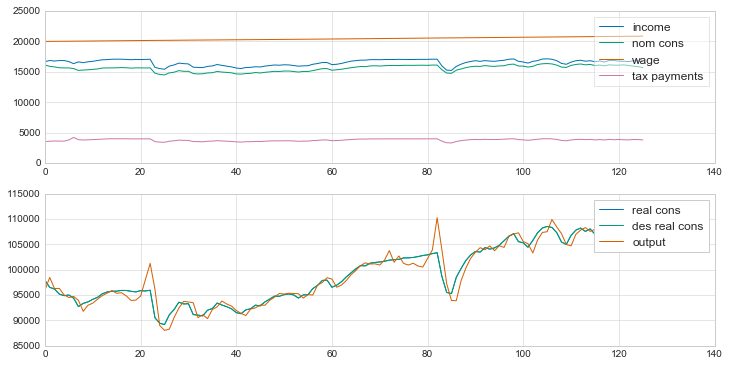

In [157]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))

ax1.plot(hhAvNetIncome.index[START:PERIODEND], hhAvNetIncome[START:PERIODEND] * 4000, label='income')
ax1.plot(nomCons.index[START:PERIODEND], nomCons[START:PERIODEND], label='nom cons')
ax1.plot(hhAvWage.index[START:PERIODEND], hhAvWage[START:PERIODEND] * 4000, label='wage')
ax1.plot(hhTaxPayments.index[START:PERIODEND], hhTaxPayments[START:PERIODEND], label='tax payments')
ax1.legend(frameon=True, framealpha=0.5)
ax2.plot(hhRealConsumption.index[START:PERIODEND], hhRealConsumption[START:PERIODEND], label='real cons')
ax2.plot(hhRealDesiredConsumption.index[START:PERIODEND], hhRealDesiredConsumption[START:PERIODEND], label='des real cons')
ax2.plot(cFirmOutput.index[START:PERIODEND], cFirmOutput[START:PERIODEND], label='output')
ax2.legend(frameon=True)

# 3 cFirms
## 3.1 Real investment demand

In [27]:
realInvDem = aggregateMicroData(allRuns('cFirmsRealDesiredInvestment'), 1)

cFirmsRealDesiredInvestment1.csv


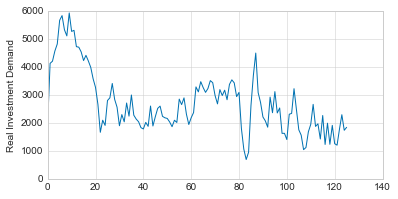

In [158]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(realInvDem.index[START:PERIODEND], realInvDem[START:PERIODEND])
ax1.set_ylabel('Real Investment Demand')

## 3.2 Profits and capacity utilization

In [29]:
profits = aggregateMicroData(allRuns('cFirmsProfits'), 1)
capUtil = averageMicroData(allRuns('cFirmsCapacityUtilization'), 1)

cFirmsProfits1.csv
cFirmsCapacityUtilization1.csv


In [30]:
ocf = averageMicroData(allRuns('cFirmsOCF'), 1)

cFirmsOCF1.csv


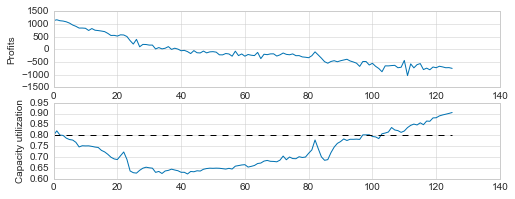

In [165]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,3))

ax1.plot(profits.index[START:PERIODEND], profits[START:PERIODEND])
ax1.set_ylabel('Profits')
ax2.plot(capUtil.index[START:PERIODEND], capUtil[START:PERIODEND])
ax2.plot(capUtil.index[START:PERIODEND], [0.8 for x in capUtil.index[START:PERIODEND]], 'k--')
ax2.set_ylabel('Capacity utilization')

## 3.3 cFirm Income & costs

In [79]:
prices = averageMicroData(allRuns('cFirmsPrices'), 1)
realSales = averageMicroData(allRuns('cFirmsRealSales'), 1)
nomSales = averageMicroData(allRuns('cFirmsNominalSales'), 1)
wages = averageMicroData(allRuns('cFirmsWageBill'), 1)
debtService = averageMicroData(allRuns('cFirmsDebtService'), 1)

cFirmsPrices1.csv
cFirmsRealSales1.csv
cFirmsNominalSales1.csv
cFirmsWageBill1.csv
cFirmsDebtService1.csv


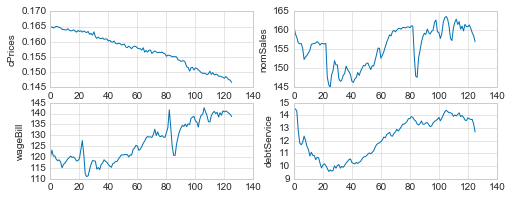

In [160]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,3))

ax1.plot(prices.index[START:PERIODEND], prices[START:PERIODEND])
ax1.set_ylabel('cPrices')
ax2.plot(nomSales.index[START:PERIODEND], nomSales[START:PERIODEND])
ax2.set_ylabel('nomSales')
ax3.plot(wages.index[START:PERIODEND], wages[START:PERIODEND])
ax3.set_ylabel('wageBill')
ax4.plot(debtService.index[START:PERIODEND], debtService[START:PERIODEND])
ax4.set_ylabel('debtService')

## 3.4 cGoods Market

In [34]:
cfBalanceSheets = renameBalanceSheetColumns(allRuns('aggCFBS'))
cfColumns = cfBalanceSheets.columns.values
cfConsGoods = cfBalanceSheets[[x for x in cfColumns if 'consumer-goods' in x]]

aggCFBS1.csv


In [35]:
changeInInventories = cfConsGoods.diff(periods=1, axis=0)
changeInInventories['aggCFBS1-consumer-goods'][0]

nan

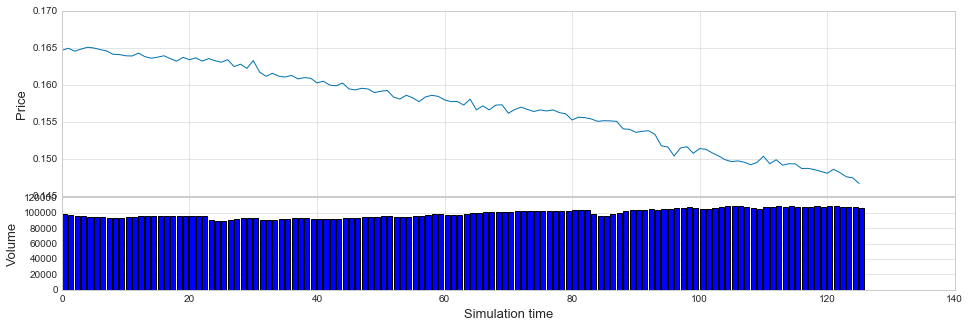

In [161]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,5), sharex=True, gridspec_kw={'height_ratios':[2,1]})

ax1.plot(cPrices.index[START:PERIODEND], cPrices[START:PERIODEND])

ax2.bar(hhRealConsumption.index[START:PERIODEND], hhRealConsumption[START:PERIODEND]['agg-1-'].apply(int))

ax2.set_xlabel('Simulation time', fontsize='13')    

ax1.set_ylabel('Price', fontsize='13')
ax2.set_ylabel('Volume', fontsize='13')
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.01)

#ax1.legend(frameon=True, loc='best')

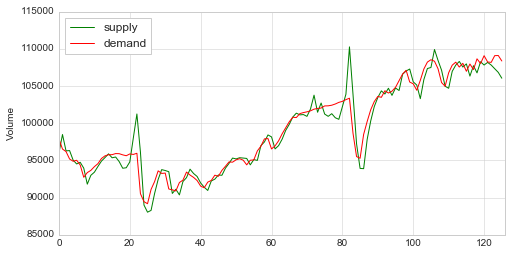

In [162]:
# demand: hhRealDesiredConsumption
# supply: cFirmOutput + (delta)inventories
fig, ax1 = plt.subplots(1, 1, figsize=(8,4))

ax1.set_ylabel('Volume')
ax1.set_xlim(START, PERIODEND)

ax1.plot(cFirmOutput.index[START:PERIODEND], cFirmOutput[START:PERIODEND]['agg-1-'].apply(int), color='green', label='supply')
ax1.plot(hhRealDesiredConsumption.index[START:PERIODEND], hhRealDesiredConsumption[START:PERIODEND]['agg-1-'].apply(int), color='red', label='demand')
#ax1.scatter(hhRealConsumption.index[START:PERIODEND], hhRealConsumption[START:PERIODEND])

ax1.legend(frameon=True, loc='best')

# 4 Capital firms

In [37]:
kPrices = averageMicroData(allRuns('kFirmsPrices'), 1)
kBankruptcies = read_csv('kFirmsBankrupcty1.csv', header=None).drop(0,1)
kBankruptcies.rename(columns={1:'bankr'}, inplace=True)
kRealSales = averageMicroData(allRuns('kFirmsRealSales'), 1)
kNomSales = averageMicroData(allRuns('kFirmsNominalSales'), 1)
kWages = averageMicroData(allRuns('kFirmsWageBill'), 1)
kDebtService = averageMicroData(allRuns('kFirmsDebtService'), 1)
kProfits = aggregateMicroData(allRuns('kFirmsProfits'), 1)
kFirmsDesiredOutput = averageMicroData(allRuns('kFirmsDesiredOutput'), 1)
kFirmOutput = aggregateMicroData(allRuns('kFirmsOutput'), 1)

kFirmsPrices1.csv
kFirmsRealSales1.csv
kFirmsNominalSales1.csv
kFirmsWageBill1.csv
kFirmsDebtService1.csv
kFirmsProfits1.csv
kFirmsDesiredOutput1.csv
kFirmsOutput1.csv


**Interestingly, kFirms don't seem to go bankrupt even with sales collapsing. I suspect this is the case because they are able to fire all employees without going bankrupt??**

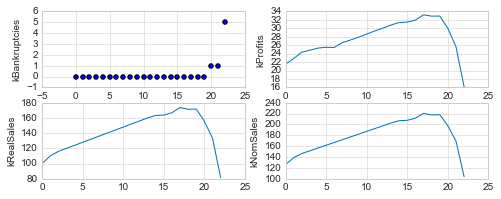

In [83]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,3))

ax1.scatter(kBankruptcies.index[START:PERIODEND], kBankruptcies[START:PERIODEND])
ax1.set_ylabel('kBankruptcies')
ax2.plot(kProfits.index[START:PERIODEND], kProfits[START:PERIODEND])
ax2.set_ylabel('kProfits')
ax3.plot(kRealSales.index[START:PERIODEND], kRealSales[START:PERIODEND])
ax3.set_ylabel('kRealSales')
ax4.plot(kNomSales.index[START:PERIODEND], kNomSales[START:PERIODEND])
ax4.set_ylabel('kNomSales')

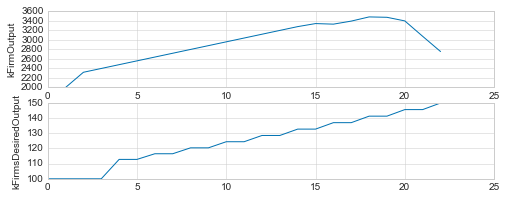

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,3))

ax1.plot(kFirmOutput.index[START:PERIODEND], kFirmOutput[START:PERIODEND])
ax1.set_ylabel('kFirmOutput')
ax2.plot(kFirmsDesiredOutput.index[START:PERIODEND], kFirmsDesiredOutput[START:PERIODEND])
ax2.set_ylabel('kFirmsDesiredOutput')

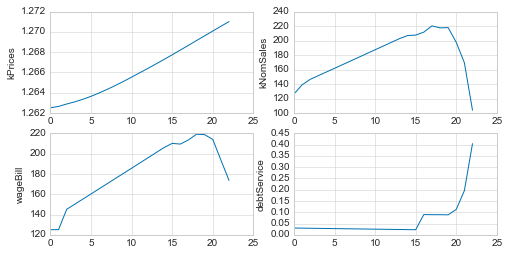

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,4))

ax1.plot(kPrices.index[START:PERIODEND], kPrices[START:PERIODEND])
ax1.set_ylabel('kPrices')
ax2.plot(kNomSales.index[START:PERIODEND], kNomSales[START:PERIODEND])
ax2.set_ylabel('kNomSales')
ax3.plot(kWages.index[START:PERIODEND], kWages[START:PERIODEND])
ax3.set_ylabel('wageBill')
ax4.plot(kDebtService.index[START:PERIODEND], kDebtService[START:PERIODEND])
ax4.set_ylabel('debtService')

# 4 Banks

## 4.1 Interest rates

In [41]:
banksLoanInterestRate = averageMicroData(allRuns('banksLoanInterestRate'),1)
banksDepAvInterest = averageMicroData(allRuns('banksDepAvInterest'),1)

banksLoanInterestRate1.csv
banksDepAvInterest1.csv


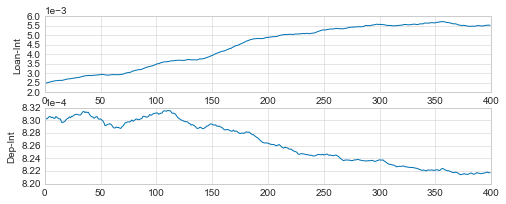

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,3))

ax1.plot(banksLoanInterestRate.index[START:PERIODEND], banksLoanInterestRate[START:PERIODEND])
ax1.set_ylabel('Loan-Int')
ax2.plot(banksDepAvInterest.index[START:PERIODEND], banksDepAvInterest[START:PERIODEND])
ax2.set_ylabel('Dep-Int')

for ax in (ax1, ax2):
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

## 4.2 Profitability

In [43]:
banksProfits = aggregateMicroData(allRuns('banksProfits'),1)
banksTotalCredit = aggregateMicroData(allRuns('banksTotalCredit'),1)
banksTaxes = aggregateMicroData(allRuns('banksTaxes'),1)
banksBankrupcty = allRuns('banksBankrupcty')
banksLossBadDebt = aggregateMicroData(allRuns('banksLossBadDebt'),1)

banksProfits1.csv
banksTotalCredit1.csv
banksBankrupcty1.csv
banksLossBadDebt1.csv


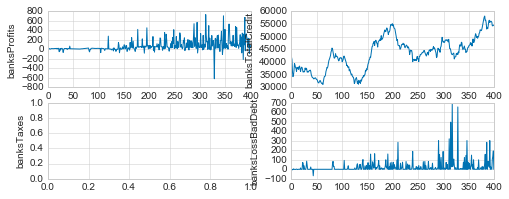

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,3))

ax1.plot(banksProfits.index[START:PERIODEND], banksProfits[START:PERIODEND])
ax1.set_ylabel('banksProfits')
ax2.plot(banksTotalCredit.index[START:PERIODEND], banksTotalCredit[START:PERIODEND])
ax2.set_ylabel('banksTotalCredit')
#ax3.plot(banksTaxes.index[START:PERIODEND], banksTaxes[START:PERIODEND])
ax3.set_ylabel('banksTaxes')
ax4.plot(banksLossBadDebt.index[START:PERIODEND], banksLossBadDebt[START:PERIODEND])
ax4.set_ylabel('banksLossBadDebt')

## 4.3 Capital and liquidity

In [45]:
banksCapitalRatio = averageMicroData(allRuns('banksCapitalRatio'),1)
banksLiquidityRatio = averageMicroData(allRuns('banksLiquidityRatio'),1)

banksCapitalRatio1.csv
banksLiquidityRatio1.csv


In [46]:
microBanksTargtedCR = allRuns('microBanksTargtedCR')
microBanksTargtedLR = allRuns('microBanksTargtedLR')

microBanksTargtedCR1.csv
microBanksTargtedLR1.csv


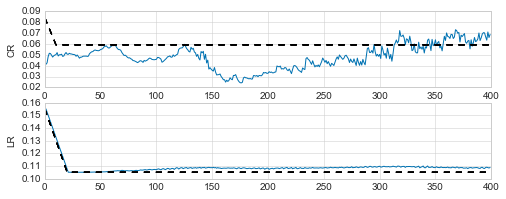

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,3))

ax1.plot(banksCapitalRatio.index[START:PERIODEND], banksCapitalRatio[START:PERIODEND])
ax1.plot(microBanksTargtedCR.index[START:PERIODEND], microBanksTargtedCR[START:PERIODEND], 'k--', label='Required')
ax1.set_ylabel('CR')
ax2.plot(banksLiquidityRatio.index[START:PERIODEND], banksLiquidityRatio[START:PERIODEND])
ax2.plot(microBanksTargtedLR.index[START:PERIODEND], microBanksTargtedLR[START:PERIODEND], 'k--', label='Required')
ax2.set_ylabel('LR')

for ax in (ax1, ax2):
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

## 4.4 Interbank market

In [48]:
microCBAdvancesRate = allRuns('microCBAdvancesRate')
microCBBankRate = allRuns('microCBBankRate')
microInterbankRate = averageMicroData(allRuns('microInterbankRate'),1)
microInterbankSupply = aggregateMicroData(allRuns('microInterbankSupply'),1)
microInterbankDemand = aggregateMicroData(allRuns('microInterbankDemand'),1)
microTotalInterBankCreditObtained = aggregateMicroData(allRuns('microTotalInterBankCreditObtained'),1)

microCBAdvancesRate1.csv
microCBBankRate1.csv
microInterbankRate1.csv
microInterbankSupply1.csv
microInterbankDemand1.csv
microTotalInterBankCreditObtained1.csv


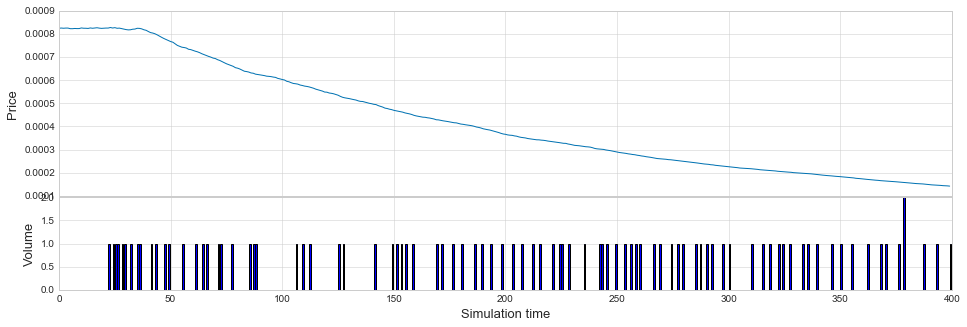

In [49]:
# Three subplots sharing both x/y axes
#fig, ((ax1, ax2)) = plt.subplots(2, figsize=(6, 6), sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,5), sharex=True, gridspec_kw={'height_ratios':[2,1]})

ax1.plot(microInterbankRate.index[START:PERIODEND], microInterbankRate[START:PERIODEND])
#ax1.plot(microCBAdvancesRate.index[START:PERIODEND], microCBAdvancesRate[START:PERIODEND], 'k--')
#ax1.plot(microCBBankRate.index[START:PERIODEND], microCBBankRate[START:PERIODEND], 'k--')

ax2.bar(microTotalInterBankCreditObtained.index[START:PERIODEND], microTotalInterBankCreditObtained[START:PERIODEND]['agg-1-'].apply(int))
#ax2.scatter(microInterbankSupply.index[START:PERIODEND], microInterbankSupply[START:PERIODEND]['agg-1-'].apply(int))
#ax2.scatter(microInterbankDemand.index[START:PERIODEND], microInterbankDemand[START:PERIODEND]['agg-1-'].apply(int))

ax2.set_xlabel('Simulation time', fontsize='13')    

ax1.set_ylabel('Price', fontsize='13')
ax2.set_ylabel('Volume', fontsize='13')
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.01)

#ax1.legend(frameon=True, loc='best')

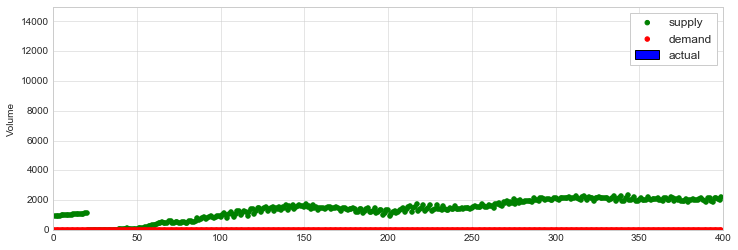

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,4))

ax1.set_ylabel('Volume')
ax1.set_xlim(START, PERIODEND)
ax1.set_ylim(0, 15000)

ax1.bar(microTotalInterBankCreditObtained.index[START:PERIODEND], microTotalInterBankCreditObtained[START:PERIODEND]['agg-1-'].apply(int), label='actual')
ax1.scatter(microInterbankSupply.index[START:PERIODEND], microInterbankSupply[START:PERIODEND]['agg-1-'].apply(int), color='green', label='supply')
ax1.scatter(microInterbankDemand.index[START:PERIODEND], microInterbankDemand[START:PERIODEND]['agg-1-'].apply(int), color='red', label='demand')

ax1.legend(frameon=True, loc='best')

## 4.5 Deposit market 

In [51]:
DepIntRate + 

SyntaxError: invalid syntax (<ipython-input-51-8a30d73ef205>, line 1)

## 4.6 Credit market

In [52]:
# 1 . loan intRate
# 2. Credit obtained / Credit constrained? 
kCreditObtained = aggregateMicroData(allRuns('kCreditObtained'), 1)
cCreditObtained = aggregateMicroData(allRuns('cFirmsCreditObtained'), 1)

kCreditObtained1.csv
cFirmsCreditObtained1.csv


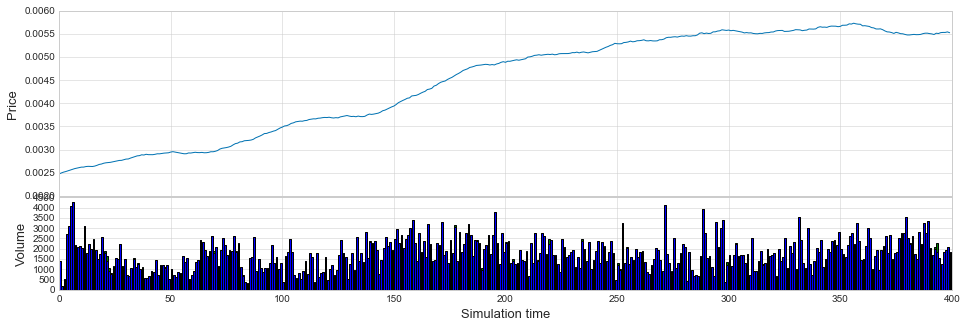

In [53]:
# Three subplots sharing both x/y axes
#fig, ((ax1, ax2)) = plt.subplots(2, figsize=(6, 6), sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,5), sharex=True, gridspec_kw={'height_ratios':[2,1]})

ax1.plot(banksLoanInterestRate.index[START:PERIODEND], banksLoanInterestRate[START:PERIODEND])

ax2.bar(cCreditObtained.index[START:PERIODEND], cCreditObtained[START:PERIODEND]['agg-1-'].apply(int), label='cCredit')
ax2.bar(kCreditObtained.index[START:PERIODEND], kCreditObtained[START:PERIODEND]['agg-1-'].apply(int), 
        bottom=cCreditObtained[START:PERIODEND]['agg-1-'].apply(int), color='g', label='kCredit')

ax2.set_xlabel('Simulation time', fontsize='13')    

ax1.set_ylabel('Price', fontsize='13')
ax2.set_ylabel('Volume', fontsize='13')
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.01)

#ax1.legend(frameon=True, loc='best')